In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from nltk.corpus import stopwords

In [3]:
stop_words = stopwords.words('spanish')

In [4]:
pd.options.display.max_rows = 30

In [5]:
df_producto = pd.read_csv('input/producto_tabla.csv.gz', compression='gzip')
df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')

In [6]:
df_producto['short_names'] = df_producto.NombreProducto.str.extract('^(\D*)')

In [7]:
df_producto['short_names_processed'] = df_producto['short_names'].map(lambda x: " ".join([i for i in x.lower().split() if i not in stopwords.words('spanish')]))

In [8]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")
print(stemmer.stem("Tortillas"))

tortill


In [9]:
df_producto['short_names_processed'] = (df_producto['short_names_processed']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))



In [10]:
df_aux_producto = df_producto['short_names_processed'].value_counts()[df_producto['short_names_processed'].value_counts() > 10].reset_index()

In [11]:
# df_producto = df_producto.ix[df_producto.short_names_processed.isin(df_aux_producto['index'])]

In [12]:
df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
df_producto = pd.DataFrame(df_producto.loc[1:])
df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

reg = '(\d{1,5}P)'
df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
df_producto = df_producto.append(aux)

df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')

# df_producto

In [13]:
df_townstate.ix[df_townstate.State.str.contains("ESTADO DE MÉXICO"), 'State'] = 'MÉXICO, D.F.'
df_townstate['Ag'] = df_townstate.Town.str.contains('AG.') * 1

In [14]:
df_week = pd.read_csv('input/train_week3.csv')

In [15]:
# df_week.Venta_uni_hoy.hist(range=(0,300), bins=50)

In [16]:
gb = df_week[['Producto_ID','Venta_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_hoy'] == gb['Venta_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_hoy'].isnull(),'Venta_hoy'] = 0
df_producto = aux

In [17]:
gb = df_week[['Producto_ID','Venta_uni_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_uni_hoy'] == gb['Venta_uni_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_uni_hoy'].isnull(),'Venta_uni_hoy'] = 0
df_producto = aux

In [18]:
gb = df_week[['Producto_ID','Dev_uni_proxima']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Dev_uni_proxima'] == gb['Dev_uni_proxima'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Dev_uni_proxima'].isnull(),'Dev_uni_proxima'] = 0
df_producto = aux

In [19]:
def count_entregas(df, by):
    df['entregas_'+by] = 1
    aux = df.groupby([by]).agg({"entregas_"+by:np.size}).reset_index()
    df.drop('entregas_'+by, axis=1, inplace=True)
    return df.merge(aux, how='left', on=by)

In [47]:
def process_df(df):
    df = pd.DataFrame(df.ix[df.Demanda_uni_equil < 51])
    df = df.drop(['Venta_uni_hoy','Venta_hoy','Dev_uni_proxima'], axis=1)
    df = df.merge(df_producto, how='left',on='Producto_ID')
    df = df.merge(df_townstate[['Agencia_ID','Ag','State']], on='Agencia_ID')
#     df = df.drop(['Agencia_ID','Dev_uni_proxima','Dev_proxima','Venta_hoy','Venta_uni_hoy'], axis=1)
    df.volume = df.volume.fillna(0).astype('int')
#     df_fabricante = df[['fabricante']]
#     df_fabricante = df_fabricante.groupby('fabricante').count().reset_index()
#     df_fabricante['index_fabricante'] = df_fabricante.index
#     df = df.merge(df_fabricante, on='fabricante')
    df.shape
    df = df.ix[df.volume<500]
    
    df = df.ix[df.Demanda_uni_equil<20]
    
    df = df.ix[df.Producto_ID != 0]
        
    df['Cliente_ID'] = df['Cliente_ID'].astype('str')
    df['Agencia_ID'] = df['Agencia_ID'].astype('str')
    df['Canal_ID'] = df['Canal_ID'].astype('str')
    df['Ruta_SAK'] = df['Ruta_SAK'].astype('str')
    
        
    lbls = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70''70-80''90-100']
    
    f = (df['volume'] < 600)
    df['volume_bin'] = pd.cut(df.volume.astype('float').values, 6, labels=lbls[0:6])    
    
    f = (df['Venta_hoy'] < 100)
    df['venta_hoy_bin'] = pd.cut(df.Venta_hoy.astype('float').values, 10, labels=lbls[0,10])
    
    f = (df['Venta_uni_hoy'] < 10)
    df['venta_uni_hoy_bin'] = pd.cut(df['venta_uni_hoy'].values, 5,lbls[0:5])
    
    
    aux = df[cols+['Demanda_uni_equil']].drop_duplicates()
        
    y = aux['Demanda_uni_equil'].values
    x = pd.get_dummies(aux[cols]).values
    return x, y, df

In [48]:
# df_process['fabricante'].value_counts()

In [49]:
cols = [
#     'volume',
#     'entregas_Producto_ID',
#     'Cliente_ID',
#     'entregas_fabricante',
#     'Agencia_ID',
#     'Ruta_SAK',
#     'Canal_ID',
#     'venta_uni_hoy_bin',
    'venta_hoy_bin',
#     'short_names_processed',
#     'State',
    'volume_bin'
]

In [50]:
def binarize(df,field, size, increment):
    df[field+'_bin'] = '-100000'
    for i in range(increment,size,increment):
        f = (df[field] < i) & (df[field] > (i -increment))
        df.ix[f, field+'_bin'] = '%s-%s' % (i-increment, i)
    return df
        

In [51]:
# df_week = pd.read_csv('input/train_week3.csv')

In [52]:
# df_week.columns

In [64]:
aux.volume = aux.volume.astype(float)

In [65]:
lbls = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70''70-80''90-100']

f = (aux['volume'] < 600)
aux = aux.ix[f]
aux['volume_bin'] = pd.cut(aux.volume.astype('float').values, 6, labels=lbls[0:6])    


In [62]:
aux = df_week[['Producto_ID']].merge(df_producto, how='left', on='Producto_ID')

In [54]:
aux['volume_bin'] = pd.cut(aux.volume.astype('float').values, 6, labels=['0-10','10-20','20-30','30-40','40-50','50-60'])

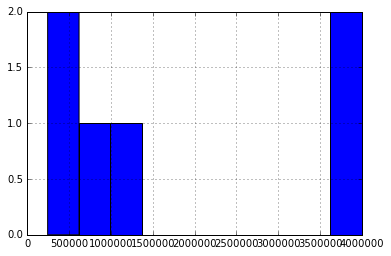

In [67]:
aux.groupby('volume_bin').size().hist()

In [ ]:
aux

In [31]:
aux = binarize(aux, 'Venta_hoy', 100, 10)

Venta_hoy_bin
-100000     612963
0-10          7706
10-20      2299600
20-30      2450032
30-40      3408840
40-50      1394255
50-60       750108
60-70        40577
70-80       177904
80-90        23221
dtype: int64

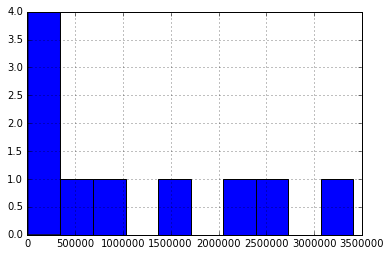

In [40]:
aux['count']=1
aux['Venta_hoy_bin'].value_counts().hist()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# rf = ExtraTreesRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)

rf = ExtraTreesRegressor(n_jobs=4)

def train(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=1729)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    print(mean_squared_error(y_test, y_pred))
        

In [ ]:
# print(mean_squared_error(y[train], y_pred))

In [ ]:
# df_producto[df_producto.Producto_ID == 1216]

In [ ]:
# df.merge(df_producto, how='left',on='Producto_ID')

In [ ]:
# df_process

In [ ]:
# df_process[cols]

In [ ]:
for df in pd.read_csv('input/train_week3.csv', chunksize=1e6):
    x,y,df_process = process_df(df)
    train(x,y)

In [ ]:
12.33

In [ ]:
# df_process['short_names_processed']

In [ ]:
# pd.get_dummies(df_process[0:100][cols])

In [ ]:
a = pd.get_dummies(df_process[cols])

In [ ]:
rf.feature_importances_.shape

In [ ]:
a.columns

In [ ]:
plt.bar(range(0,18), height=rf.feature_importances_)

In [ ]:
f = plt.subplots()
i = 444
for v in x.T:
    i+=1
    f.hist(v)

In [ ]:
df.columns

In [ ]:
count_entregas(df, 'Agencia_ID')